In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_targets_t1_normalized_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 1380)
(734160, 1)
validation
(101248, 1380)
(101248, 1)
test
(100432, 1380)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1380)]            0         


 dense (Dense)               (None, 1024)              1414144   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 2103297 (8.02 MB)


Trainable params: 2103297 (8.02 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 2:01 - loss: 0.0751 - STD: 1.5854e-04 - MAE: 0.2581

 3/74 [>.............................] - ETA: 2s - loss: 0.0329 - STD: 5.3724e-04 - MAE: 0.1423  

 5/74 [=>............................] - ETA: 2s - loss: 0.0285 - STD: 4.5505e-04 - MAE: 0.1319

 7/74 [=>............................] - ETA: 2s - loss: 0.0276 - STD: 3.6685e-04 - MAE: 0.1312

 9/74 [==>...........................] - ETA: 2s - loss: 0.0270 - STD: 2.9814e-04 - MAE: 0.1303

11/74 [===>..........................] - ETA: 2s - loss: 0.0260 - STD: 2.4833e-04 - MAE: 0.1274

13/74 [====>.........................] - ETA: 2s - loss: 0.0245 - STD: 2.2224e-04 - MAE: 0.1225

15/74 [=====>........................] - ETA: 2s - loss: 0.0228 - STD: 2.1076e-04 - MAE: 0.1166

17/74 [=====>........................] - ETA: 2s - loss: 0.0212 - STD: 2.0692e-04 - MAE: 0.1119

19/74 [======>.......................] - ETA: 2s - loss: 0.0201 - STD: 2.0549e-04 - MAE: 0.1094

21/74 [=======>......................] - ETA: 2s - loss: 0.0194 - STD: 2.0274e-04 - MAE: 0.1083

23/74 [========>.....................] - ETA: 1s - loss: 0.0188 - STD: 1.9746e-04 - MAE: 0.1069

25/74 [=========>....................] - ETA: 1s - loss: 0.0181 - STD: 1.8975e-04 - MAE: 0.1048

27/74 [=========>....................] - ETA: 1s - loss: 0.0174 - STD: 1.8061e-04 - MAE: 0.1026

29/74 [==========>...................] - ETA: 1s - loss: 0.0169 - STD: 1.7120e-04 - MAE: 0.1006

31/74 [===========>..................] - ETA: 1s - loss: 0.0165 - STD: 1.6230e-04 - MAE: 0.0990

33/74 [============>.................] - ETA: 1s - loss: 0.0161 - STD: 1.5427e-04 - MAE: 0.0975

35/74 [=============>................] - ETA: 1s - loss: 0.0157 - STD: 1.4726e-04 - MAE: 0.0962

37/74 [==============>...............] - ETA: 1s - loss: 0.0154 - STD: 1.4129e-04 - MAE: 0.0950

39/74 [==============>...............] - ETA: 1s - loss: 0.0151 - STD: 1.3624e-04 - MAE: 0.0940

41/74 [===============>..............] - ETA: 1s - loss: 0.0148 - STD: 1.3195e-04 - MAE: 0.0932

43/74 [================>.............] - ETA: 1s - loss: 0.0146 - STD: 1.2816e-04 - MAE: 0.0926

45/74 [=================>............] - ETA: 1s - loss: 0.0143 - STD: 1.2464e-04 - MAE: 0.0920

47/74 [==================>...........] - ETA: 1s - loss: 0.0141 - STD: 1.2127e-04 - MAE: 0.0914

49/74 [==================>...........] - ETA: 0s - loss: 0.0139 - STD: 1.1797e-04 - MAE: 0.0907

51/74 [===================>..........] - ETA: 1s - loss: 0.0138 - STD: 1.1480e-04 - MAE: 0.0901

53/74 [====================>.........] - ETA: 1s - loss: 0.0136 - STD: 1.1181e-04 - MAE: 0.0895

55/74 [=====================>........] - ETA: 0s - loss: 0.0135 - STD: 1.0906e-04 - MAE: 0.0890

57/74 [======================>.......] - ETA: 0s - loss: 0.0133 - STD: 1.0658e-04 - MAE: 0.0885

59/74 [======================>.......] - ETA: 0s - loss: 0.0132 - STD: 1.0436e-04 - MAE: 0.0880

61/74 [=======================>......] - ETA: 0s - loss: 0.0131 - STD: 1.0241e-04 - MAE: 0.0876

63/74 [========================>.....] - ETA: 0s - loss: 0.0129 - STD: 1.0065e-04 - MAE: 0.0873

65/74 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 9.9034e-05 - MAE: 0.0870

67/74 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 9.7531e-05 - MAE: 0.0866

69/74 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 9.6105e-05 - MAE: 0.0863

71/74 [===========================>..] - ETA: 0s - loss: 0.0125 - STD: 9.4759e-05 - MAE: 0.0860

73/74 [============================>.] - ETA: 0s - loss: 0.0124 - STD: 9.3495e-05 - MAE: 0.0857

74/74 [==============================] - 6s 63ms/step - loss: 0.0124 - STD: 9.2890e-05 - MAE: 0.0855 - val_loss: 0.0086 - val_STD: 1.8957e-05 - val_MAE: 0.0712


Epoch 2/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0093 - STD: 5.0218e-05 - MAE: 0.0756

 3/74 [>.............................] - ETA: 2s - loss: 0.0092 - STD: 5.1145e-05 - MAE: 0.0750

 5/74 [=>............................] - ETA: 2s - loss: 0.0093 - STD: 5.2148e-05 - MAE: 0.0752

 7/74 [=>............................] - ETA: 2s - loss: 0.0093 - STD: 5.3188e-05 - MAE: 0.0754

 9/74 [==>...........................] - ETA: 2s - loss: 0.0093 - STD: 5.4222e-05 - MAE: 0.0754

11/74 [===>..........................] - ETA: 2s - loss: 0.0092 - STD: 5.5129e-05 - MAE: 0.0754

13/74 [====>.........................] - ETA: 2s - loss: 0.0092 - STD: 5.6027e-05 - MAE: 0.0754

15/74 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 5.6727e-05 - MAE: 0.0755

17/74 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 5.7409e-05 - MAE: 0.0755

19/74 [======>.......................] - ETA: 2s - loss: 0.0092 - STD: 5.8023e-05 - MAE: 0.0753

21/74 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 5.8674e-05 - MAE: 0.0753

23/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 5.9410e-05 - MAE: 0.0753

25/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 6.0256e-05 - MAE: 0.0754

27/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 6.1106e-05 - MAE: 0.0754

29/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 6.2001e-05 - MAE: 0.0754

31/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 6.2838e-05 - MAE: 0.0754

33/74 [============>.................] - ETA: 1s - loss: 0.0093 - STD: 6.3624e-05 - MAE: 0.0755

35/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 6.4446e-05 - MAE: 0.0754

37/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 6.5310e-05 - MAE: 0.0754

39/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 6.6103e-05 - MAE: 0.0754

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 6.6946e-05 - MAE: 0.0754

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 6.7814e-05 - MAE: 0.0754

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 6.8703e-05 - MAE: 0.0754

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 6.9604e-05 - MAE: 0.0755

49/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 7.0563e-05 - MAE: 0.0755

51/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 7.1516e-05 - MAE: 0.0755

53/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 7.2465e-05 - MAE: 0.0755

55/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 7.3466e-05 - MAE: 0.0755

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.4495e-05 - MAE: 0.0754

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.5551e-05 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 7.6634e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 7.7723e-05 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 7.8818e-05 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 7.9942e-05 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 8.1097e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 8.2269e-05 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 8.3465e-05 - MAE: 0.0754

74/74 [==============================] - 3s 43ms/step - loss: 0.0092 - STD: 8.4072e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 6.0188e-05 - val_MAE: 0.0716


Epoch 3/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0094 - STD: 1.3082e-04 - MAE: 0.0759

 3/74 [>.............................] - ETA: 2s - loss: 0.0093 - STD: 1.3229e-04 - MAE: 0.0755

 5/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 1.3396e-04 - MAE: 0.0757

 7/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 1.3552e-04 - MAE: 0.0754

 9/74 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 1.3697e-04 - MAE: 0.0752

11/74 [===>..........................] - ETA: 2s - loss: 0.0092 - STD: 1.3840e-04 - MAE: 0.0754

13/74 [====>.........................] - ETA: 2s - loss: 0.0092 - STD: 1.4037e-04 - MAE: 0.0753

15/74 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 1.4233e-04 - MAE: 0.0754

17/74 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 1.4431e-04 - MAE: 0.0754

19/74 [======>.......................] - ETA: 2s - loss: 0.0092 - STD: 1.4645e-04 - MAE: 0.0754

21/74 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 1.4846e-04 - MAE: 0.0754

23/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 1.5032e-04 - MAE: 0.0754

25/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 1.5241e-04 - MAE: 0.0753

27/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 1.5466e-04 - MAE: 0.0753

29/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 1.5688e-04 - MAE: 0.0753

31/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 1.5914e-04 - MAE: 0.0753

33/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 1.6145e-04 - MAE: 0.0754

35/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 1.6393e-04 - MAE: 0.0753

37/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 1.6636e-04 - MAE: 0.0753

39/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 1.6900e-04 - MAE: 0.0753

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 1.7162e-04 - MAE: 0.0753

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.7418e-04 - MAE: 0.0753

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.7690e-04 - MAE: 0.0754

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.7984e-04 - MAE: 0.0754

49/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 1.8296e-04 - MAE: 0.0754

51/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 1.8611e-04 - MAE: 0.0754

53/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 1.8925e-04 - MAE: 0.0754

55/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 1.9235e-04 - MAE: 0.0754

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.9560e-04 - MAE: 0.0754

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.9885e-04 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 2.0230e-04 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.0612e-04 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 2.1004e-04 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.1395e-04 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.1805e-04 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 2.2234e-04 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 2.2663e-04 - MAE: 0.0754

74/74 [==============================] - 3s 43ms/step - loss: 0.0092 - STD: 2.2884e-04 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 2.0093e-04 - val_MAE: 0.0712


Epoch 4/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0092 - STD: 3.8757e-04 - MAE: 0.0748

 3/74 [>.............................] - ETA: 3s - loss: 0.0093 - STD: 3.9908e-04 - MAE: 0.0753

 5/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 4.0956e-04 - MAE: 0.0751

 7/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 4.2098e-04 - MAE: 0.0752

 9/74 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 4.3160e-04 - MAE: 0.0753

11/74 [===>..........................] - ETA: 2s - loss: 0.0092 - STD: 4.4053e-04 - MAE: 0.0753

13/74 [====>.........................] - ETA: 2s - loss: 0.0092 - STD: 4.4902e-04 - MAE: 0.0753

15/74 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 4.5649e-04 - MAE: 0.0753

17/74 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 4.6547e-04 - MAE: 0.0752

19/74 [======>.......................] - ETA: 2s - loss: 0.0092 - STD: 4.7500e-04 - MAE: 0.0752

21/74 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 4.8666e-04 - MAE: 0.0752

23/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 4.9816e-04 - MAE: 0.0752

25/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 5.0937e-04 - MAE: 0.0752

27/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 5.2062e-04 - MAE: 0.0752

29/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 5.3268e-04 - MAE: 0.0753

31/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 5.4528e-04 - MAE: 0.0753

33/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 5.5886e-04 - MAE: 0.0753

35/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 5.7276e-04 - MAE: 0.0753

37/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 5.8739e-04 - MAE: 0.0753

39/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 6.0202e-04 - MAE: 0.0753

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 6.1705e-04 - MAE: 0.0753

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 6.3320e-04 - MAE: 0.0752

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 6.5030e-04 - MAE: 0.0752

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 6.6759e-04 - MAE: 0.0752

49/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 6.8597e-04 - MAE: 0.0752

51/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 7.0567e-04 - MAE: 0.0752

53/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 7.2658e-04 - MAE: 0.0752

55/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 7.4841e-04 - MAE: 0.0752

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.7078e-04 - MAE: 0.0752

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.9373e-04 - MAE: 0.0752

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 8.1914e-04 - MAE: 0.0752

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 8.4612e-04 - MAE: 0.0752

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 8.7541e-04 - MAE: 0.0753

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 9.0637e-04 - MAE: 0.0753

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 9.3782e-04 - MAE: 0.0753

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 9.7126e-04 - MAE: 0.0753

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0010 - MAE: 0.0752    

74/74 [==============================] - 3s 45ms/step - loss: 0.0092 - STD: 0.0010 - MAE: 0.0752 - val_loss: 0.0085 - val_STD: 0.0015 - val_MAE: 0.0708


Epoch 5/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0091 - STD: 0.0025 - MAE: 0.0749

 3/74 [>.............................] - ETA: 2s - loss: 0.0092 - STD: 0.0026 - MAE: 0.0751

 5/74 [=>............................] - ETA: 2s - loss: 0.0091 - STD: 0.0027 - MAE: 0.0748

 7/74 [=>............................] - ETA: 2s - loss: 0.0090 - STD: 0.0028 - MAE: 0.0748

 9/74 [==>...........................] - ETA: 2s - loss: 0.0090 - STD: 0.0029 - MAE: 0.0749

11/74 [===>..........................] - ETA: 2s - loss: 0.0090 - STD: 0.0030 - MAE: 0.0748

13/74 [====>.........................] - ETA: 2s - loss: 0.0091 - STD: 0.0031 - MAE: 0.0749

15/74 [=====>........................] - ETA: 2s - loss: 0.0091 - STD: 0.0032 - MAE: 0.0750

17/74 [=====>........................] - ETA: 2s - loss: 0.0091 - STD: 0.0033 - MAE: 0.0750

19/74 [======>.......................] - ETA: 2s - loss: 0.0091 - STD: 0.0035 - MAE: 0.0749

21/74 [=======>......................] - ETA: 2s - loss: 0.0091 - STD: 0.0036 - MAE: 0.0749

23/74 [========>.....................] - ETA: 1s - loss: 0.0090 - STD: 0.0038 - MAE: 0.0748

25/74 [=========>....................] - ETA: 1s - loss: 0.0090 - STD: 0.0039 - MAE: 0.0748

27/74 [=========>....................] - ETA: 1s - loss: 0.0090 - STD: 0.0041 - MAE: 0.0747

29/74 [==========>...................] - ETA: 1s - loss: 0.0090 - STD: 0.0043 - MAE: 0.0746

31/74 [===========>..................] - ETA: 1s - loss: 0.0090 - STD: 0.0045 - MAE: 0.0745

33/74 [============>.................] - ETA: 1s - loss: 0.0089 - STD: 0.0047 - MAE: 0.0745

35/74 [=============>................] - ETA: 1s - loss: 0.0089 - STD: 0.0049 - MAE: 0.0745

37/74 [==============>...............] - ETA: 1s - loss: 0.0089 - STD: 0.0051 - MAE: 0.0745

39/74 [==============>...............] - ETA: 1s - loss: 0.0089 - STD: 0.0054 - MAE: 0.0744

41/74 [===============>..............] - ETA: 1s - loss: 0.0089 - STD: 0.0056 - MAE: 0.0744

43/74 [================>.............] - ETA: 1s - loss: 0.0089 - STD: 0.0059 - MAE: 0.0743

45/74 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.0062 - MAE: 0.0743

47/74 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0065 - MAE: 0.0742

49/74 [==================>...........] - ETA: 0s - loss: 0.0088 - STD: 0.0068 - MAE: 0.0742

51/74 [===================>..........] - ETA: 0s - loss: 0.0088 - STD: 0.0072 - MAE: 0.0741

53/74 [====================>.........] - ETA: 0s - loss: 0.0088 - STD: 0.0076 - MAE: 0.0740

55/74 [=====================>........] - ETA: 0s - loss: 0.0088 - STD: 0.0079 - MAE: 0.0740

57/74 [======================>.......] - ETA: 0s - loss: 0.0088 - STD: 0.0083 - MAE: 0.0739

59/74 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.0088 - MAE: 0.0738

61/74 [=======================>......] - ETA: 0s - loss: 0.0087 - STD: 0.0092 - MAE: 0.0737

63/74 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0097 - MAE: 0.0736

65/74 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.0101 - MAE: 0.0735

67/74 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0106 - MAE: 0.0734

69/74 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0111 - MAE: 0.0733

71/74 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.0116 - MAE: 0.0732

73/74 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.0121 - MAE: 0.0732

74/74 [==============================] - 3s 43ms/step - loss: 0.0086 - STD: 0.0123 - MAE: 0.0731 - val_loss: 0.0071 - val_STD: 0.0234 - val_MAE: 0.0643


Epoch 6/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0076 - STD: 0.0306 - MAE: 0.0688

 3/74 [>.............................] - ETA: 2s - loss: 0.0077 - STD: 0.0316 - MAE: 0.0696

 5/74 [=>............................] - ETA: 2s - loss: 0.0076 - STD: 0.0318 - MAE: 0.0692

 7/74 [=>............................] - ETA: 2s - loss: 0.0076 - STD: 0.0321 - MAE: 0.0687

 9/74 [==>...........................] - ETA: 2s - loss: 0.0075 - STD: 0.0325 - MAE: 0.0687

11/74 [===>..........................] - ETA: 2s - loss: 0.0075 - STD: 0.0329 - MAE: 0.0687

13/74 [====>.........................] - ETA: 2s - loss: 0.0075 - STD: 0.0330 - MAE: 0.0684

15/74 [=====>........................] - ETA: 2s - loss: 0.0075 - STD: 0.0334 - MAE: 0.0684

17/74 [=====>........................] - ETA: 2s - loss: 0.0075 - STD: 0.0336 - MAE: 0.0683

19/74 [======>.......................] - ETA: 2s - loss: 0.0074 - STD: 0.0337 - MAE: 0.0680

21/74 [=======>......................] - ETA: 1s - loss: 0.0074 - STD: 0.0341 - MAE: 0.0680

23/74 [========>.....................] - ETA: 1s - loss: 0.0074 - STD: 0.0344 - MAE: 0.0678

25/74 [=========>....................] - ETA: 1s - loss: 0.0073 - STD: 0.0346 - MAE: 0.0675

27/74 [=========>....................] - ETA: 1s - loss: 0.0073 - STD: 0.0349 - MAE: 0.0674

29/74 [==========>...................] - ETA: 1s - loss: 0.0073 - STD: 0.0353 - MAE: 0.0673

31/74 [===========>..................] - ETA: 1s - loss: 0.0073 - STD: 0.0356 - MAE: 0.0672

33/74 [============>.................] - ETA: 1s - loss: 0.0073 - STD: 0.0359 - MAE: 0.0670

35/74 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.0362 - MAE: 0.0669

37/74 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.0366 - MAE: 0.0667

39/74 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.0370 - MAE: 0.0666

41/74 [===============>..............] - ETA: 1s - loss: 0.0072 - STD: 0.0373 - MAE: 0.0664

43/74 [================>.............] - ETA: 1s - loss: 0.0071 - STD: 0.0377 - MAE: 0.0662

45/74 [=================>............] - ETA: 1s - loss: 0.0071 - STD: 0.0381 - MAE: 0.0660

47/74 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0385 - MAE: 0.0659

49/74 [==================>...........] - ETA: 0s - loss: 0.0070 - STD: 0.0389 - MAE: 0.0657

51/74 [===================>..........] - ETA: 0s - loss: 0.0070 - STD: 0.0393 - MAE: 0.0656

53/74 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.0397 - MAE: 0.0655

55/74 [=====================>........] - ETA: 0s - loss: 0.0070 - STD: 0.0401 - MAE: 0.0655

57/74 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0402 - MAE: 0.0655

59/74 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0404 - MAE: 0.0658

61/74 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0405 - MAE: 0.0660

63/74 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0406 - MAE: 0.0661

65/74 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0405 - MAE: 0.0660

67/74 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0406 - MAE: 0.0661

69/74 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0404 - MAE: 0.0660

71/74 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0404 - MAE: 0.0661

73/74 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0403 - MAE: 0.0660

74/74 [==============================] - 3s 44ms/step - loss: 0.0072 - STD: 0.0402 - MAE: 0.0660 - val_loss: 0.0063 - val_STD: 0.0260 - val_MAE: 0.0589


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0069 - STD: 0.0355 - MAE: 0.0627

 3/74 [>.............................] - ETA: 2s - loss: 0.0068 - STD: 0.0380 - MAE: 0.0657

 5/74 [=>............................] - ETA: 2s - loss: 0.0067 - STD: 0.0376 - MAE: 0.0644

 7/74 [=>............................] - ETA: 2s - loss: 0.0067 - STD: 0.0374 - MAE: 0.0636

 9/74 [==>...........................] - ETA: 2s - loss: 0.0067 - STD: 0.0383 - MAE: 0.0640

11/74 [===>..........................] - ETA: 2s - loss: 0.0066 - STD: 0.0385 - MAE: 0.0635

13/74 [====>.........................] - ETA: 2s - loss: 0.0066 - STD: 0.0390 - MAE: 0.0632

15/74 [=====>........................] - ETA: 2s - loss: 0.0066 - STD: 0.0397 - MAE: 0.0632

17/74 [=====>........................] - ETA: 2s - loss: 0.0065 - STD: 0.0401 - MAE: 0.0630

19/74 [======>.......................] - ETA: 2s - loss: 0.0065 - STD: 0.0408 - MAE: 0.0630

21/74 [=======>......................] - ETA: 2s - loss: 0.0065 - STD: 0.0413 - MAE: 0.0628

23/74 [========>.....................] - ETA: 1s - loss: 0.0065 - STD: 0.0419 - MAE: 0.0626

25/74 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0424 - MAE: 0.0624

27/74 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0430 - MAE: 0.0624

29/74 [==========>...................] - ETA: 1s - loss: 0.0064 - STD: 0.0436 - MAE: 0.0623

31/74 [===========>..................] - ETA: 1s - loss: 0.0064 - STD: 0.0441 - MAE: 0.0622

33/74 [============>.................] - ETA: 1s - loss: 0.0064 - STD: 0.0446 - MAE: 0.0621

35/74 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0451 - MAE: 0.0620

37/74 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0455 - MAE: 0.0620

39/74 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0460 - MAE: 0.0619

41/74 [===============>..............] - ETA: 1s - loss: 0.0063 - STD: 0.0464 - MAE: 0.0618

43/74 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0468 - MAE: 0.0618

45/74 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.0471 - MAE: 0.0617

47/74 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0475 - MAE: 0.0616

49/74 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0478 - MAE: 0.0615

51/74 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0481 - MAE: 0.0615

53/74 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0484 - MAE: 0.0614

55/74 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0487 - MAE: 0.0613

57/74 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0489 - MAE: 0.0613

59/74 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0491 - MAE: 0.0612

61/74 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0493 - MAE: 0.0612

63/74 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0495 - MAE: 0.0611

65/74 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0497 - MAE: 0.0611

67/74 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0498 - MAE: 0.0610

69/74 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0500 - MAE: 0.0610

71/74 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0501 - MAE: 0.0609

73/74 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0503 - MAE: 0.0609

74/74 [==============================] - 3s 45ms/step - loss: 0.0062 - STD: 0.0504 - MAE: 0.0608 - val_loss: 0.0059 - val_STD: 0.0410 - val_MAE: 0.0590


Epoch 8/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0060 - STD: 0.0554 - MAE: 0.0592

 3/74 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0556 - MAE: 0.0601

 5/74 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0565 - MAE: 0.0608

 7/74 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0602

 9/74 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0547 - MAE: 0.0612

11/74 [===>..........................] - ETA: 2s - loss: 0.0064 - STD: 0.0546 - MAE: 0.0617

13/74 [====>.........................] - ETA: 2s - loss: 0.0064 - STD: 0.0538 - MAE: 0.0614

15/74 [=====>........................] - ETA: 2s - loss: 0.0064 - STD: 0.0540 - MAE: 0.0615

17/74 [=====>........................] - ETA: 2s - loss: 0.0063 - STD: 0.0533 - MAE: 0.0611

19/74 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0533 - MAE: 0.0612

21/74 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0530 - MAE: 0.0610

23/74 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0529 - MAE: 0.0609

25/74 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0528 - MAE: 0.0608

27/74 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0527 - MAE: 0.0607

29/74 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0528 - MAE: 0.0606

31/74 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0527 - MAE: 0.0605

33/74 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0529 - MAE: 0.0604

35/74 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0529 - MAE: 0.0603

37/74 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0530 - MAE: 0.0603

39/74 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0531 - MAE: 0.0602

41/74 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0532 - MAE: 0.0602

43/74 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0534 - MAE: 0.0602

45/74 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0535 - MAE: 0.0601

47/74 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0536 - MAE: 0.0600

49/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0537 - MAE: 0.0600

51/74 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0538 - MAE: 0.0599

53/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0540 - MAE: 0.0599

55/74 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0540 - MAE: 0.0598

57/74 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0542 - MAE: 0.0598

59/74 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0542 - MAE: 0.0597

61/74 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0543 - MAE: 0.0597

63/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0544 - MAE: 0.0596

65/74 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0545 - MAE: 0.0596

67/74 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0545 - MAE: 0.0595

69/74 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0546 - MAE: 0.0595

71/74 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0547 - MAE: 0.0595

73/74 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0548 - MAE: 0.0594

74/74 [==============================] - 3s 43ms/step - loss: 0.0060 - STD: 0.0548 - MAE: 0.0594 - val_loss: 0.0062 - val_STD: 0.0421 - val_MAE: 0.0599


Epoch 9/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0060 - STD: 0.0553 - MAE: 0.0579

 3/74 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0586

 5/74 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0569 - MAE: 0.0584

 7/74 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0585

 9/74 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0585

11/74 [===>..........................] - ETA: 2s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0585

13/74 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0583

15/74 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0583

17/74 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0583

19/74 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0582

21/74 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0583

23/74 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0583

25/74 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0583

27/74 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0583

29/74 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0583

31/74 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0583

33/74 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0583

35/74 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0582

37/74 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0574 - MAE: 0.0582

39/74 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0582

41/74 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0574 - MAE: 0.0582

43/74 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0574 - MAE: 0.0581

45/74 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0574 - MAE: 0.0581

47/74 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0574 - MAE: 0.0581

49/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0574 - MAE: 0.0581

51/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0575 - MAE: 0.0581

53/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0575 - MAE: 0.0581

55/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0576 - MAE: 0.0580

57/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0576 - MAE: 0.0581

59/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0576 - MAE: 0.0581

61/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0576 - MAE: 0.0580

63/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0576 - MAE: 0.0580

65/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0577 - MAE: 0.0580

67/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0577 - MAE: 0.0580

69/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0577 - MAE: 0.0580

71/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0577 - MAE: 0.0580

73/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0577 - MAE: 0.0580

74/74 [==============================] - 3s 44ms/step - loss: 0.0057 - STD: 0.0577 - MAE: 0.0580 - val_loss: 0.0062 - val_STD: 0.0455 - val_MAE: 0.0610


Epoch 10/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0057 - STD: 0.0563 - MAE: 0.0571

 3/74 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0576 - MAE: 0.0573

 5/74 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0582 - MAE: 0.0575

 7/74 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0583 - MAE: 0.0576

 9/74 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0577

11/74 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0582 - MAE: 0.0575

13/74 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0576

15/74 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0576

17/74 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0577

19/74 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0577

21/74 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0578

23/74 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0577

25/74 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0577

27/74 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0576

29/74 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0576

31/74 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0577

33/74 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0577

35/74 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0576

37/74 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0576

39/74 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0576

41/74 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0577

43/74 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0577

45/74 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0577

47/74 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0577

49/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0576

51/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0576

53/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0576

55/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0576

57/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0576

59/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0576

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0586 - MAE: 0.0576

63/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0576

65/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0577

67/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0577

69/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0577

71/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0577

73/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0577

74/74 [==============================] - 3s 44ms/step - loss: 0.0057 - STD: 0.0585 - MAE: 0.0577 - val_loss: 0.0074 - val_STD: 0.0400 - val_MAE: 0.0633


Epoch 11/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0065 - STD: 0.0484 - MAE: 0.0580

 3/74 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0600

 5/74 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0536 - MAE: 0.0590

 7/74 [=>............................] - ETA: 2s - loss: 0.0066 - STD: 0.0534 - MAE: 0.0616

 9/74 [==>...........................] - ETA: 2s - loss: 0.0069 - STD: 0.0538 - MAE: 0.0638

11/74 [===>..........................] - ETA: 2s - loss: 0.0070 - STD: 0.0514 - MAE: 0.0632

13/74 [====>.........................] - ETA: 2s - loss: 0.0070 - STD: 0.0516 - MAE: 0.0638

15/74 [=====>........................] - ETA: 2s - loss: 0.0069 - STD: 0.0500 - MAE: 0.0633

17/74 [=====>........................] - ETA: 2s - loss: 0.0069 - STD: 0.0496 - MAE: 0.0636

19/74 [======>.......................] - ETA: 2s - loss: 0.0068 - STD: 0.0487 - MAE: 0.0632

21/74 [=======>......................] - ETA: 2s - loss: 0.0068 - STD: 0.0481 - MAE: 0.0630

23/74 [========>.....................] - ETA: 1s - loss: 0.0067 - STD: 0.0479 - MAE: 0.0630

25/74 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.0475 - MAE: 0.0626

27/74 [=========>....................] - ETA: 1s - loss: 0.0066 - STD: 0.0477 - MAE: 0.0626

29/74 [==========>...................] - ETA: 1s - loss: 0.0066 - STD: 0.0476 - MAE: 0.0622

31/74 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0480 - MAE: 0.0621

33/74 [============>.................] - ETA: 1s - loss: 0.0065 - STD: 0.0483 - MAE: 0.0618

35/74 [=============>................] - ETA: 1s - loss: 0.0065 - STD: 0.0488 - MAE: 0.0617

37/74 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0492 - MAE: 0.0614

39/74 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0497 - MAE: 0.0613

41/74 [===============>..............] - ETA: 1s - loss: 0.0063 - STD: 0.0501 - MAE: 0.0611

43/74 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0506 - MAE: 0.0610

45/74 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.0510 - MAE: 0.0608

47/74 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0514 - MAE: 0.0607

49/74 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0517 - MAE: 0.0606

51/74 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0521 - MAE: 0.0605

53/74 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0523 - MAE: 0.0603

55/74 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0526 - MAE: 0.0602

57/74 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0528 - MAE: 0.0601

59/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0530 - MAE: 0.0601

61/74 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0532 - MAE: 0.0600

63/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0533 - MAE: 0.0599

65/74 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0535 - MAE: 0.0598

67/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0536 - MAE: 0.0597

69/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0538 - MAE: 0.0596

71/74 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0539 - MAE: 0.0596

73/74 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0541 - MAE: 0.0595

74/74 [==============================] - 3s 44ms/step - loss: 0.0060 - STD: 0.0541 - MAE: 0.0595 - val_loss: 0.0062 - val_STD: 0.0479 - val_MAE: 0.0619


Epoch 12/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0055 - STD: 0.0583 - MAE: 0.0567

 3/74 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0580 - MAE: 0.0570

 5/74 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0586 - MAE: 0.0574

 7/74 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0574

 9/74 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0589 - MAE: 0.0574

11/74 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0574

13/74 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0573

15/74 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0574

17/74 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0573

19/74 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0573

21/74 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0573

23/74 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0572

25/74 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0572

27/74 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0572

29/74 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0572

31/74 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0573

34/74 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0572

36/74 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0572

38/74 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0572

40/74 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0572

42/74 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0571

44/74 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0571

46/74 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0572

48/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0572

50/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0572

52/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0572

54/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0572

56/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0572

58/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0572

59/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0572

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0572

63/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0572

65/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0572

67/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0573

69/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0572

71/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0573

73/74 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0573

74/74 [==============================] - 3s 44ms/step - loss: 0.0056 - STD: 0.0591 - MAE: 0.0573 - val_loss: 0.0065 - val_STD: 0.0467 - val_MAE: 0.0621


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0056 - STD: 0.0564 - MAE: 0.0557

 3/74 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0575

 5/74 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0570

 7/74 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0570

 9/74 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0589 - MAE: 0.0573

11/74 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0585 - MAE: 0.0572

13/74 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0574

15/74 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0574

17/74 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0586 - MAE: 0.0572

19/74 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0573

21/74 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0574

23/74 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0586 - MAE: 0.0573

25/74 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0574

27/74 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0573

29/74 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0573

31/74 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0574

33/74 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0574

35/74 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0575

37/74 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0575

39/74 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0586 - MAE: 0.0574

41/74 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0575

43/74 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0574

45/74 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0574

47/74 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0574

49/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0574

51/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0574

53/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0574

55/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0574

57/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0589 - MAE: 0.0574

59/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0589 - MAE: 0.0574

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0589 - MAE: 0.0573

63/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0589 - MAE: 0.0573

65/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0573

67/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0573

69/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0573

71/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0573

73/74 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0573

74/74 [==============================] - 3s 44ms/step - loss: 0.0056 - STD: 0.0591 - MAE: 0.0573 - val_loss: 0.0063 - val_STD: 0.0522 - val_MAE: 0.0642


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0055 - STD: 0.0620 - MAE: 0.0582

 3/74 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0568

 5/74 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0603 - MAE: 0.0572

 7/74 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0572

 9/74 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0571

11/74 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0571

13/74 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0570

15/74 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0569

17/74 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0570

19/74 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0570

21/74 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0595 - MAE: 0.0569

23/74 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0596 - MAE: 0.0569

25/74 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0596 - MAE: 0.0569

27/74 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0596 - MAE: 0.0569

29/74 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0596 - MAE: 0.0569

31/74 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0596 - MAE: 0.0569

33/74 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0570

35/74 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0570

37/74 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0569

39/74 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0569

41/74 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0569

43/74 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0569

45/74 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0569

47/74 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0569

49/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0569

51/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0569

53/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0569

55/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0569

57/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0569

59/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0570

61/74 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0598 - MAE: 0.0569

63/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0569

65/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0569

67/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0570

69/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0569

71/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0570

73/74 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0570

74/74 [==============================] - 3s 42ms/step - loss: 0.0055 - STD: 0.0599 - MAE: 0.0570 - val_loss: 0.0064 - val_STD: 0.0522 - val_MAE: 0.0643


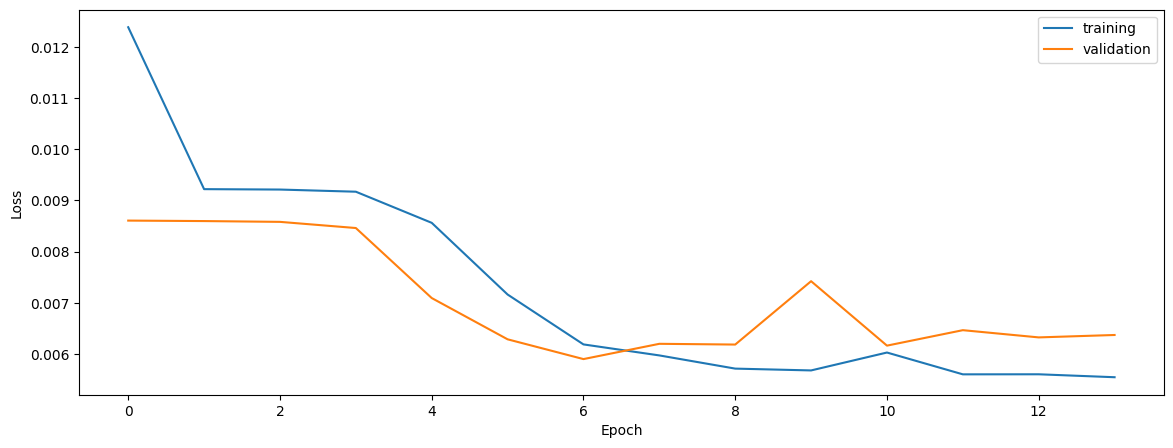

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.6011211964457391
0.5669597953389447
0.5877003829323821


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.6011211964457391
0.5669597953389447
0.5877003829323821


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.5953899172414745
0.5593490372865966
0.5942987915694073


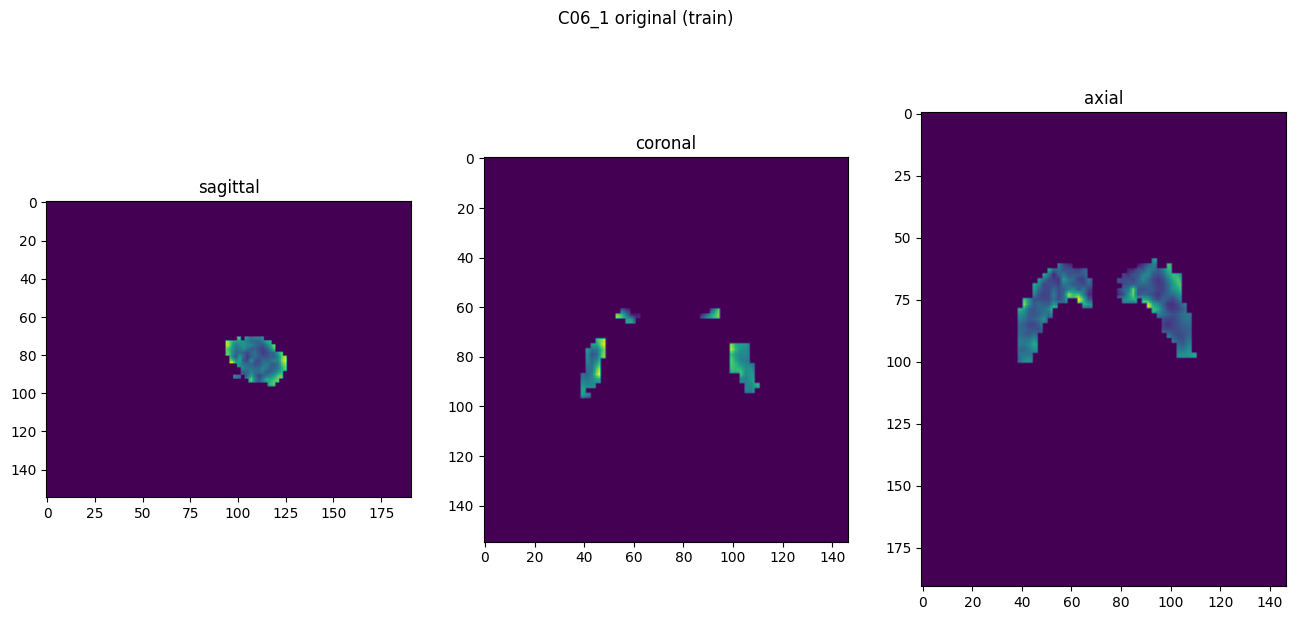

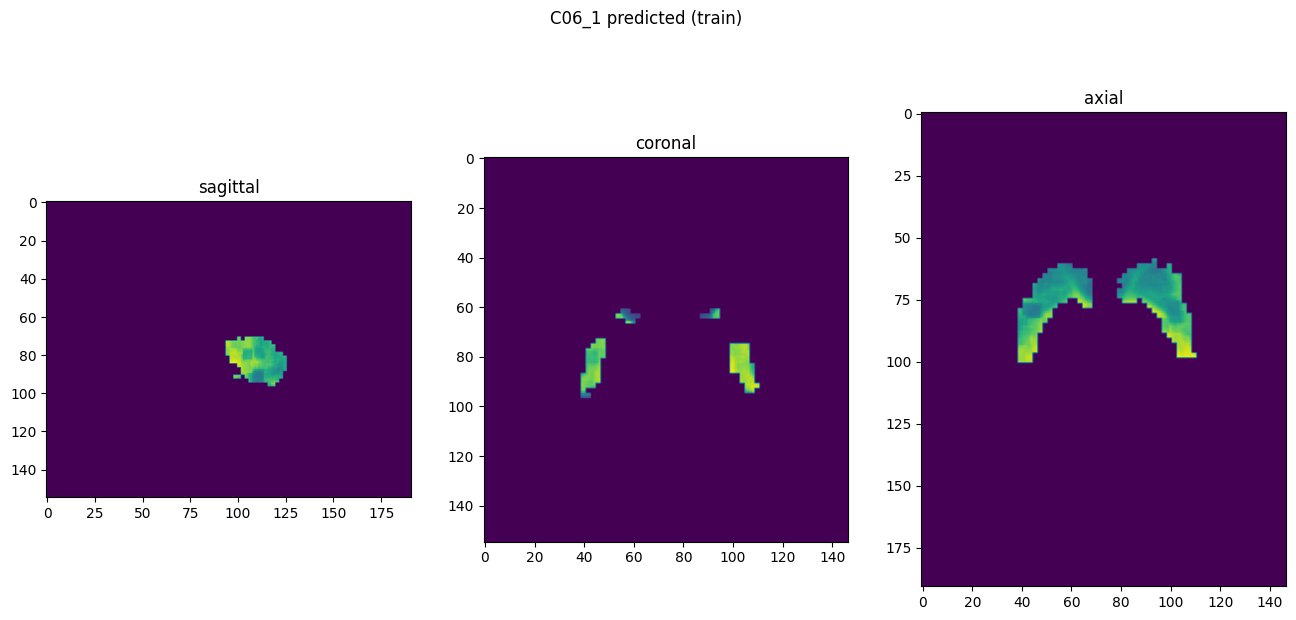

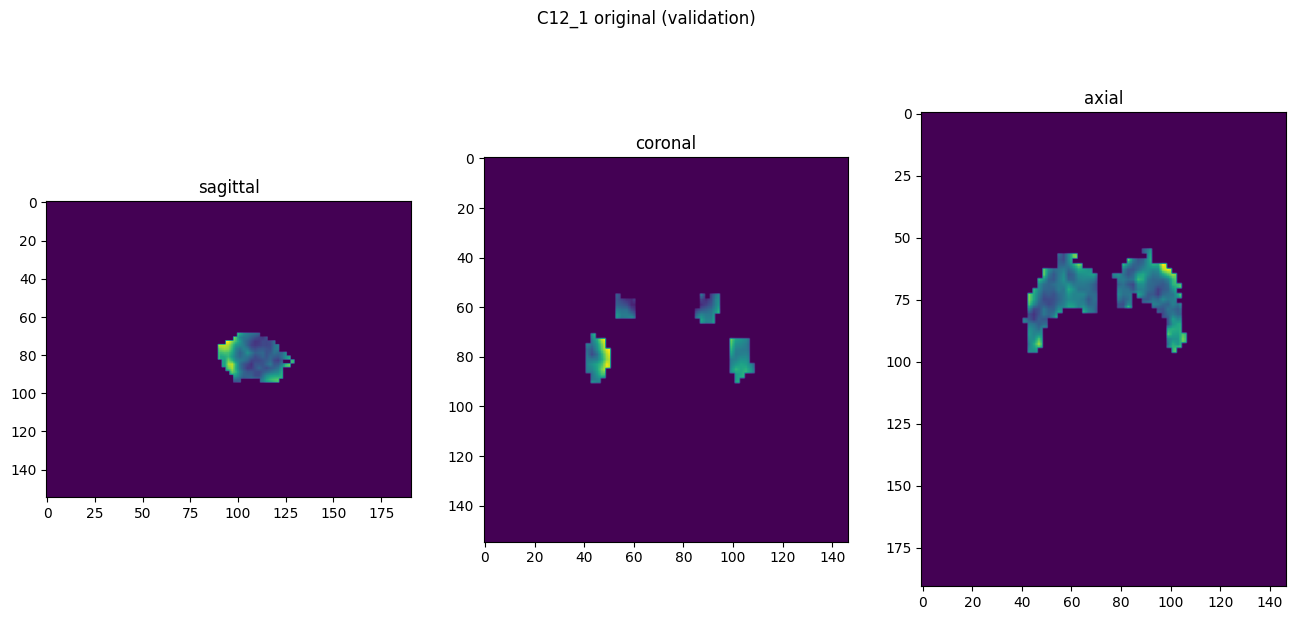

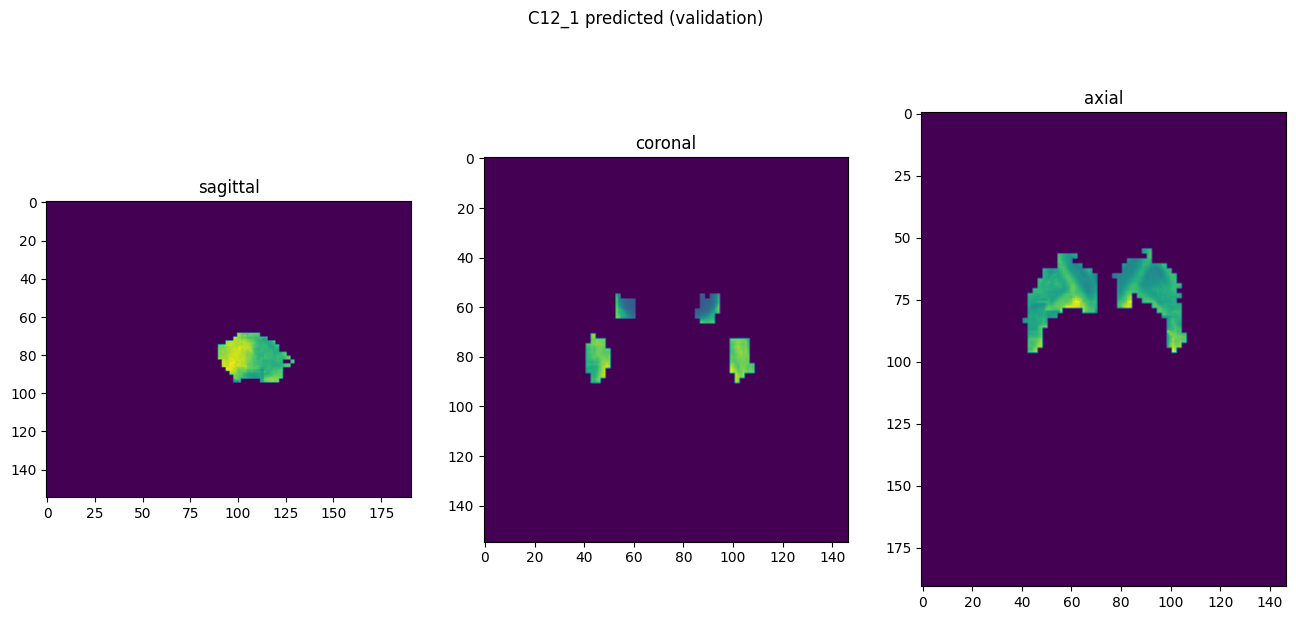

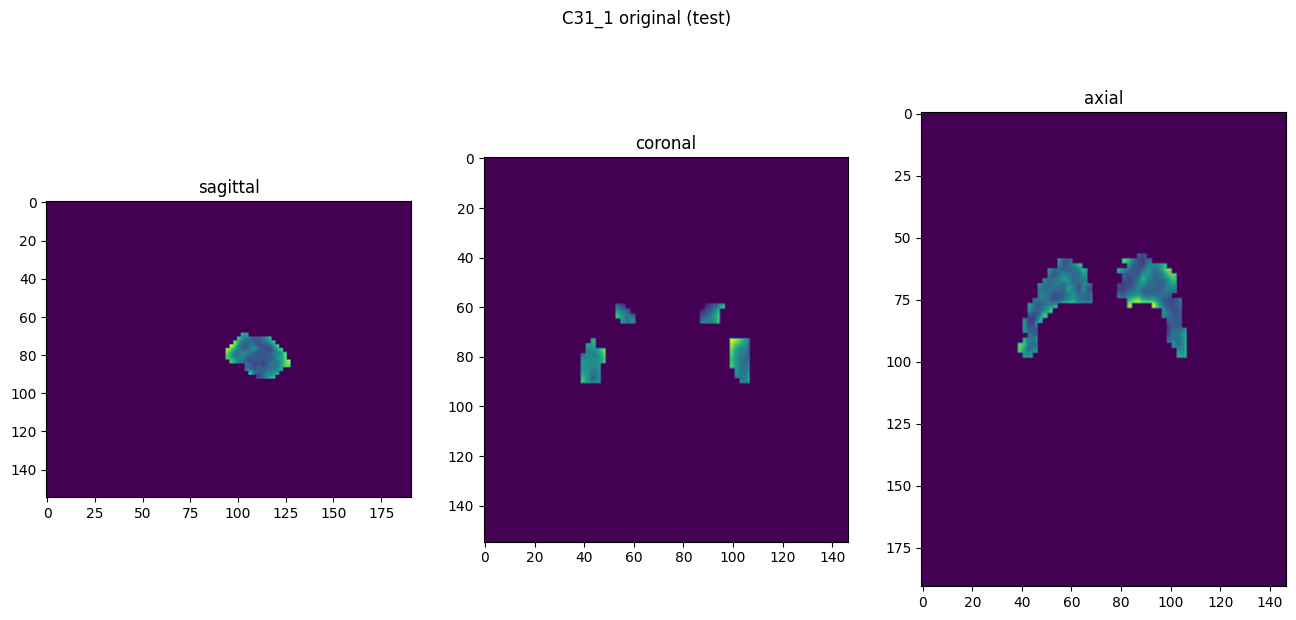

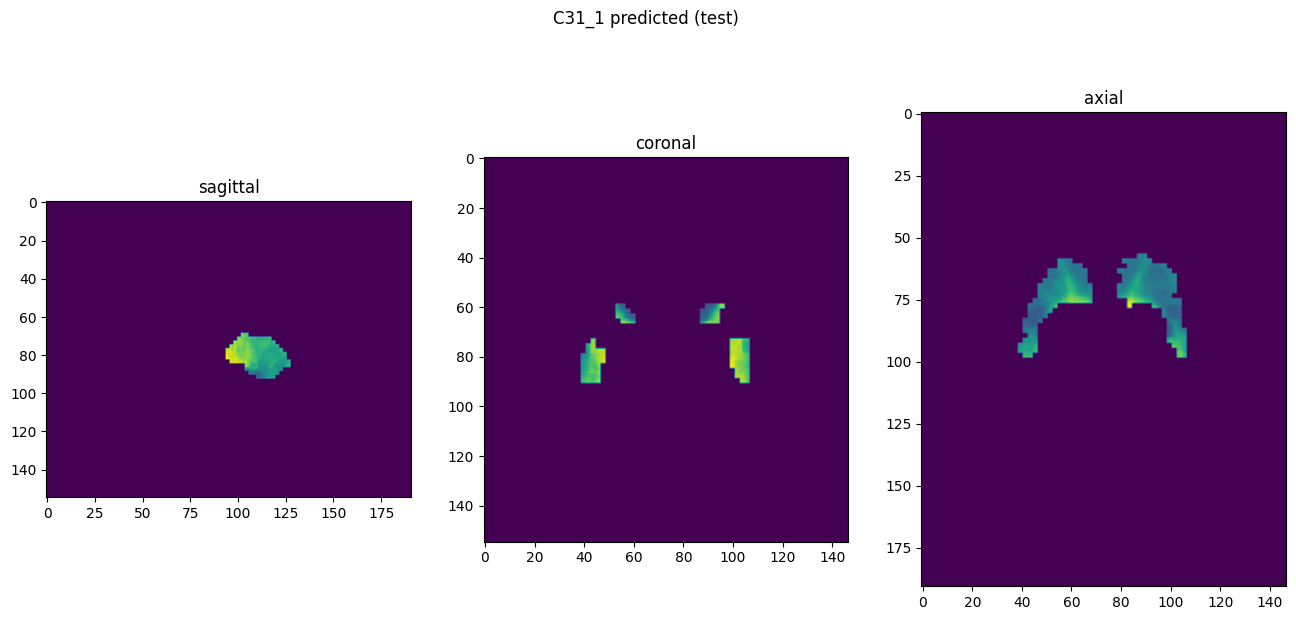

In [10]:
showResults(model, gen, threshold=None, background=False)